# Exploratory Data Analisys (EDA) #

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re
from wordcloud import WordCloud

### Lectura de dataset ###  
Se utiliza el dataset procesado "desanidado"

In [2]:
df = pd.read_csv('../dataset/MoviesDataset_v41.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44510 entries, 0 to 44509
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             44510 non-null  float64
 1   original_language  44500 non-null  object 
 2   overview           44510 non-null  object 
 3   popularity         44510 non-null  float64
 4   revenue            44510 non-null  float64
 5   runtime            44510 non-null  float64
 6   title              44510 non-null  object 
 7   btc_name           44510 non-null  object 
 8   genres             44510 non-null  object 
 9   companies          44510 non-null  object 
 10  countries          44510 non-null  object 
 11  release_year       44510 non-null  int64  
 12  return             44510 non-null  float64
 13  Directors          44510 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 4.8+ MB


### Medidas estadísticas de variables numéricas ###  
Podria haber un outlier en 'popularity' dado su valor máx = 547

In [4]:
df.describe(include=[np.number])

,budget,popularity,revenue,runtime,release_year,return
count,4.451000e+04,44510.000000,4.451000e+04,44510.000000,44510.000000,4.451000e+04
mean,4.316460e+06,2.976575,1.145466e+07,95.029769,1991.799101,6.728852e+02
std,1.760122e+07,6.058457,6.499571e+07,37.494986,24.141250,7.541638e+04
min,0.000000e+00,0.000000,0.000000e+00,0.000000,1874.000000,0.000000e+00
25%,0.000000e+00,0.406514,0.000000e+00,85.000000,1978.000000,0.000000e+00
50%,0.000000e+00,1.163834,0.000000e+00,95.000000,2001.000000,0.000000e+00
75%,0.000000e+00,3.815177,0.000000e+00,107.000000,2010.000000,0.000000e+00
max,3.800000e+08,547.488298,2.787965e+09,1256.000000,2020.000000,1.239638e+07


### Variables no numéricas ###

In [5]:
df.describe(include=object)

,original_language,overview,title,btc_name,genres,companies,countries,Directors
count,44500,44510,44510,44510,44510,44510,44510,44510
unique,89,44231,41302,1674,4045,22402,2366,18492
top,en,No overview found.,Blackout,noc,['Drama'],[],['United States of America'],[]
freq,32181,133,13,40072,4916,11267,17839,763


### Matríz de Correlación ###

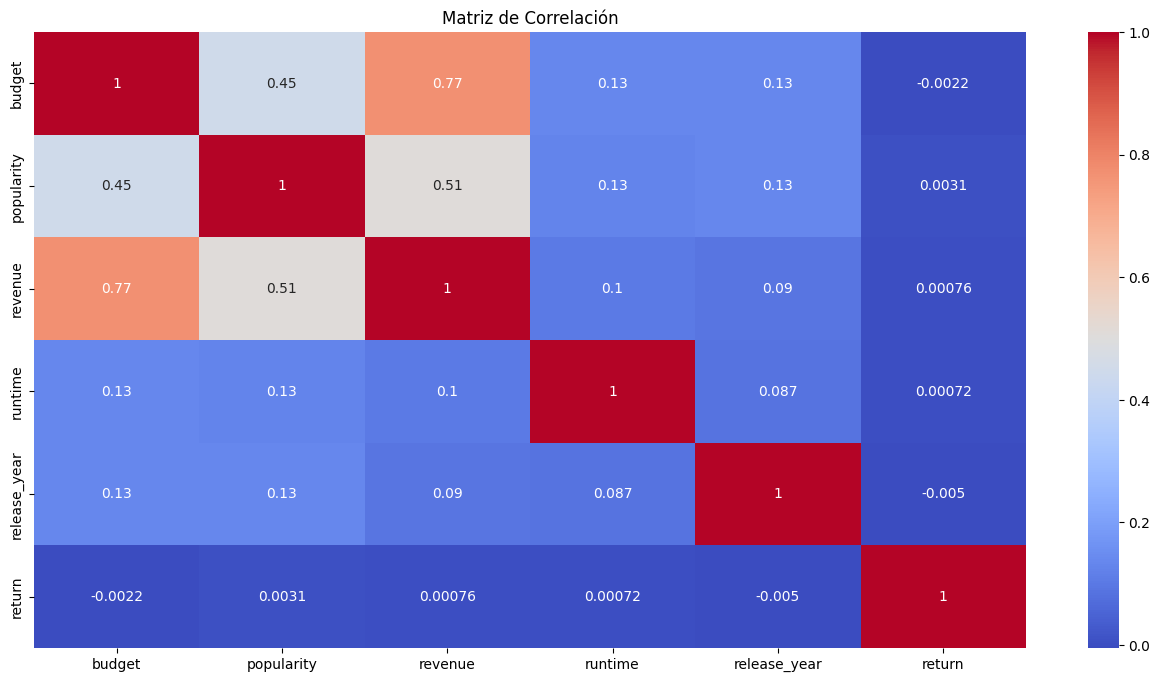

In [6]:
# se excluyen las variables no numéricas
correlation_matrix = df.select_dtypes(exclude = ['object']).corr()

plt.figure(figsize=(16,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

### Gráfico de pairplot ###  
Se observa cierta tendencia lineal entre las variables 'budget' y 'revenue' como ya se había observado en la Matríz de Correlación -> mientras más budget... más revenue

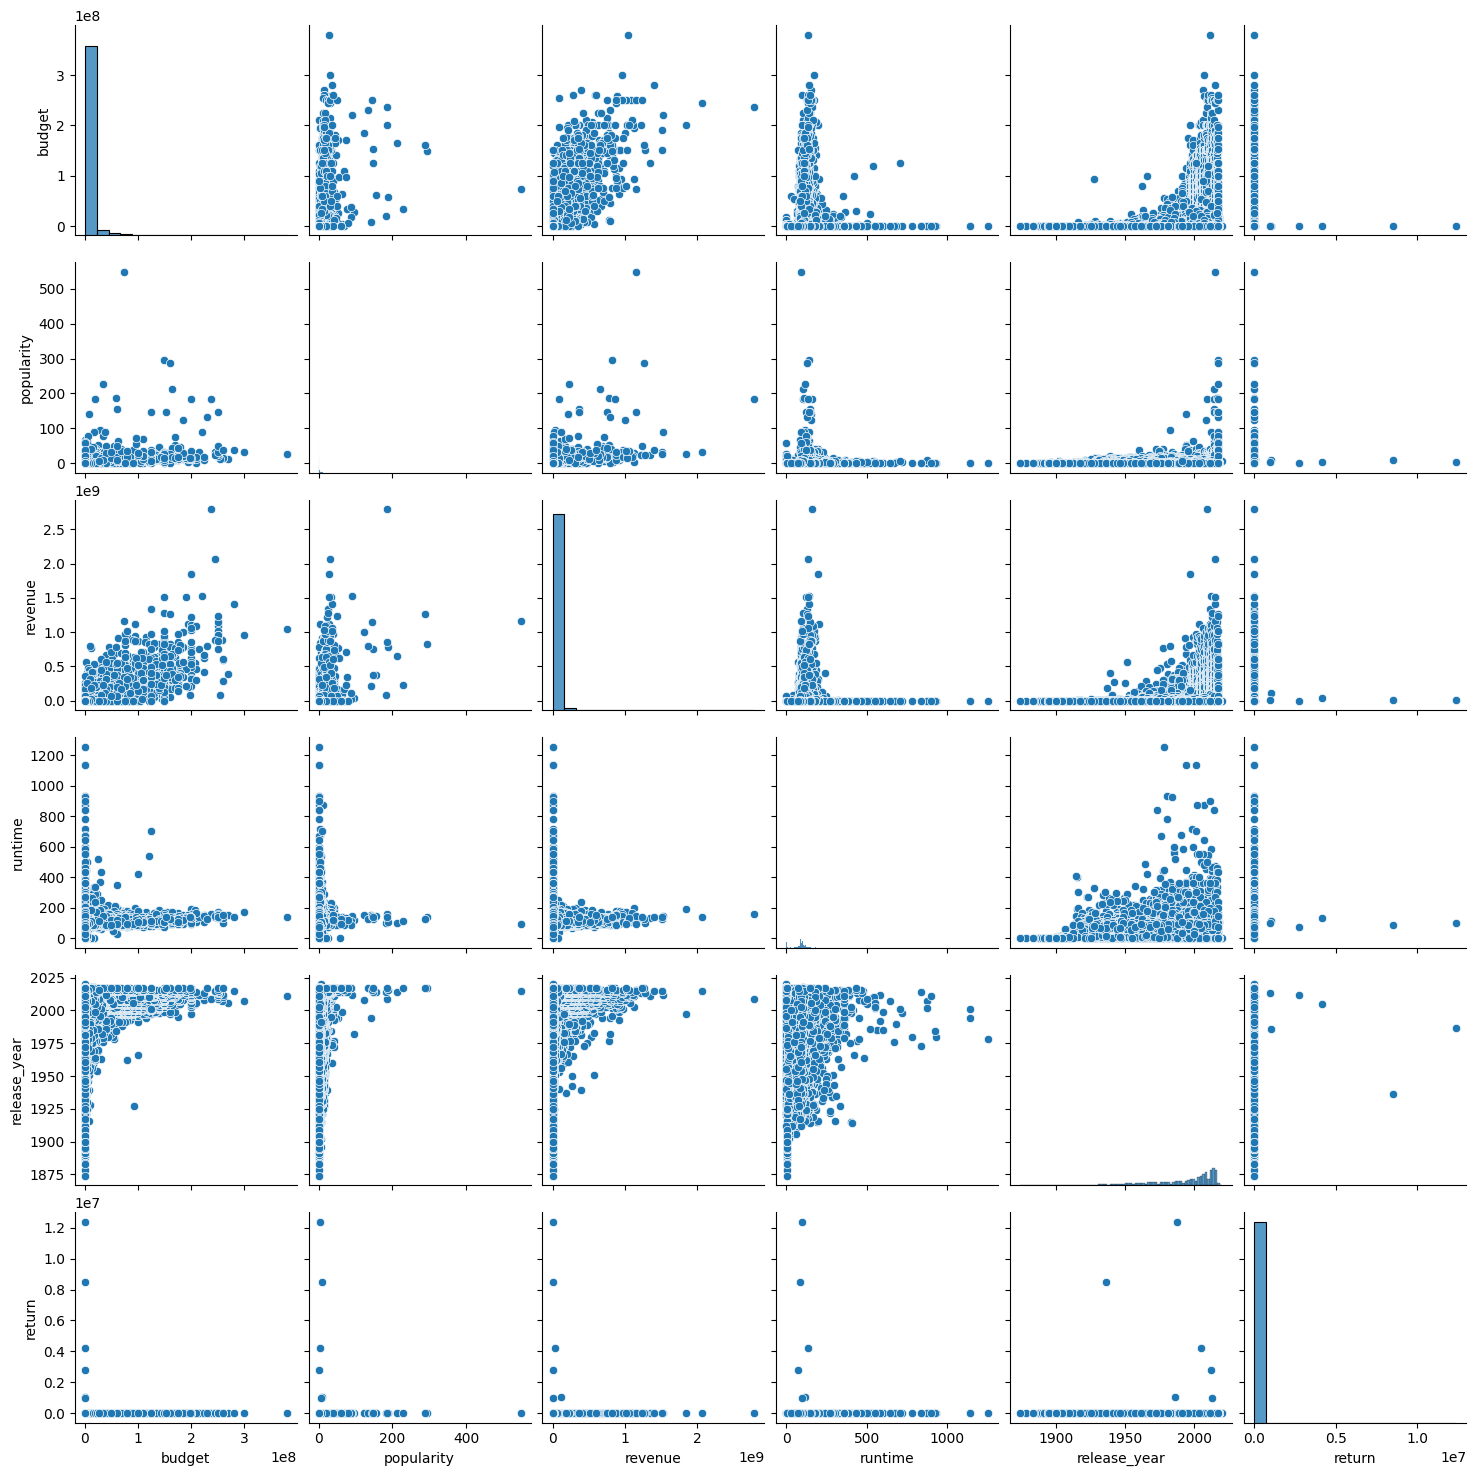

In [7]:
sns.pairplot(data=df)

### Limpieza del texto ###  


In [8]:
# Se procede a tokenizar la variable objetivo
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    if isinstance(texto, float):  # Verificar si el valor es de tipo float
        return []  # Devolver una lista vacía en caso de que sea float

    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return(nuevo_texto)

In [9]:
# Se aplica la función de limpieza y tokenización a cada pelicula
df_title = df
df['title_tokenizado'] =df['title'].apply(lambda x: limpiar_tokenizar(x))
df[['title', 'title_tokenizado']].head()

,title,title_tokenizado
0,Toy Story,"[toy, story]"
1,Jumanji,[jumanji]
2,Grumpier Old Men,"[grumpier, old, men]"
3,Waiting to Exhale,"[waiting, to, exhale]"
4,Father of the Bride Part II,"[father, of, the, bride, part, ii]"


In [10]:
# Generación de una nueva columna 'token'
title_tidy = df.explode(column='title_tokenizado')
title_tidy = title_tidy.drop(columns='title')
title_tidy = title_tidy.rename(columns={'title_tokenizado':'token'})

In [11]:
title_tidy.columns

Index(['budget', 'original_language', 'overview', 'popularity', 'revenue',
       'runtime', 'btc_name', 'genres', 'companies', 'countries',
       'release_year', 'return', 'Directors', 'token'],
      dtype='object')

In [12]:
# Se descarga el paquete Stopwords de la biblioteca nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
#stop_words.extend(("amp", "xa", "xe"))
stop_words.extend(('the', 'of', 'in', 'and', 'to', 'on', 'for', 'my', 'you', 'is', 'at'))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [14]:
# Filtrado para excluir stopwords
title_tidy = title_tidy[~(title_tidy["token"].isin(stop_words))]

### Nube de palabras ###  
Las palabras más repetidas se observan en mayor tamaño

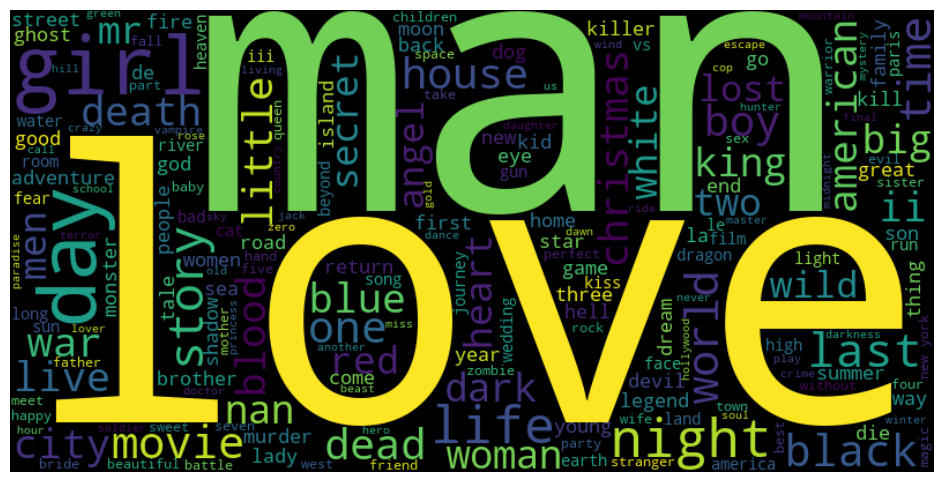

In [15]:
# Unir todos los tokens en un solo texto
all_tokens = ' '.join(title_tidy['token'].astype(str))

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_tokens)

# Mostrar la nube de palabras
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()